<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C2W2_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Download example data
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-06-07 04:49:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   128MB/s    in 0.5s    

2020-06-07 04:49:10 (128 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Extract zip files
import os
import zipfile

# Files PATH
local_zip = '/tmp/cats_and_dogs_filtered.zip'

# Extract zipfiles
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# Image file path
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [26]:
# Check filenames in the train directory
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.971.jpg', 'cat.135.jpg', 'cat.864.jpg', 'cat.467.jpg', 'cat.888.jpg', 'cat.401.jpg', 'cat.482.jpg', 'cat.865.jpg', 'cat.280.jpg', 'cat.248.jpg']
['dog.290.jpg', 'dog.303.jpg', 'dog.914.jpg', 'dog.592.jpg', 'dog.517.jpg', 'dog.381.jpg', 'dog.294.jpg', 'dog.733.jpg', 'dog.888.jpg', 'dog.188.jpg']


In [27]:
# Check the file numbers
print("train casts file numbers :", len(os.listdir(train_cats_dir)))
print("train dogs file numbers :", len(os.listdir(train_dogs_dir)))
print("validation cats file numbers :", len(os.listdir(validation_cats_dir)))
print("validation dogs file numbers :", len(os.listdir(validation_dogs_dir)))

train casts file numbers : 1000
train dogs file numbers : 1000
validation cats file numbers : 500
validation dogs file numbers : 500


In [0]:
import tensorflow as tf

In [29]:
# Data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocess by normalize the pixel values to be in the [0, 1] range
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Define callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [34]:
# Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [0]:
# Optimizer
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']   
)

In [36]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=100, # batch_size * steps_per_epoch = Images
    epochs=100,
    verbose=2,
    validation_data = validation_generator,
    validation_steps=50,
    callbacks=[callbacks]
)

Epoch 1/100
100/100 - 16s - loss: 0.7922 - accuracy: 0.5195 - val_loss: 0.6870 - val_accuracy: 0.5090
Epoch 2/100
100/100 - 16s - loss: 0.6915 - accuracy: 0.5595 - val_loss: 0.6411 - val_accuracy: 0.6600
Epoch 3/100
100/100 - 16s - loss: 0.6570 - accuracy: 0.6185 - val_loss: 0.6318 - val_accuracy: 0.6280
Epoch 4/100
100/100 - 16s - loss: 0.6371 - accuracy: 0.6515 - val_loss: 0.6346 - val_accuracy: 0.6100
Epoch 5/100
100/100 - 16s - loss: 0.6304 - accuracy: 0.6455 - val_loss: 0.5986 - val_accuracy: 0.6890
Epoch 6/100
100/100 - 16s - loss: 0.6232 - accuracy: 0.6560 - val_loss: 0.5874 - val_accuracy: 0.6870
Epoch 7/100
100/100 - 16s - loss: 0.6105 - accuracy: 0.6785 - val_loss: 0.5873 - val_accuracy: 0.6800
Epoch 8/100
100/100 - 16s - loss: 0.6014 - accuracy: 0.6860 - val_loss: 0.5835 - val_accuracy: 0.6900
Epoch 9/100
100/100 - 16s - loss: 0.5953 - accuracy: 0.6825 - val_loss: 0.5344 - val_accuracy: 0.7300
Epoch 10/100
100/100 - 16s - loss: 0.5877 - accuracy: 0.6915 - val_loss: 0.5429 - 

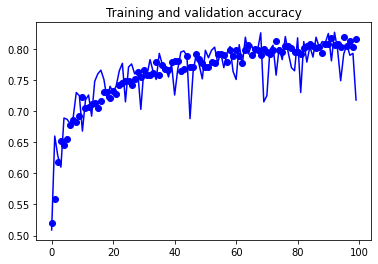

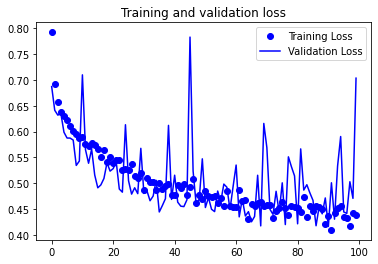

In [37]:
# Plotting accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()